# **Regression Analysis using CRISP-DM**

## 1. Business Understanding

- Objective
- Criteria for success
---

### Objectives of the Analysis

The analysis aims to achieve the following objectives:
- Explore and understand the factors affecting call volume to the virtual assistant service.
- Develop a predictive model that can forecast the call volume for the next 14 days.
- Ensure the predictive model provides a slight overestimation of call volume as a buffer.
- Provide actionable insights for staffing schedules, cost reduction, and customer service improvement.


### Criteria for Success
The success of the analysis will be measured based on:
- Accurate forecast of call volume with a tolerable margin of overestimation.
- Predictions that are actionable for daily staffing decisions.
- A model that outperforms existing baseline forecasts or historical averages.
- Stakeholder trust in the model’s outputs for decision-making.
- A model that maintains accuracy and relevance over time with new data.


## 2. Data Understanding

- Use the head() method to view the first few rows of the dataset.
- Use the info() method to understand the data types and non-null counts.
- Use the describe() method to get a statistical summary of the dataset.
- Create a histogram or a kernel density estimate (KDE) plot to see the distribution of the target variable (call volume).
- Generate a correlation heatmap to identify how features relate to each other.
- Produce pair plots or scatter plots to visualize important relationships between features and the target variable.
- Use box plots to examine the distributions of various features and identify outliers.
---

### Import Necessary Libraries and Load the Data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import datetime
from math import e
import time
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import sys
sys.path.append('../')  # Adjust the path if needed to reach the root directory

import xgboost as xgb
import pyodbc
import warnings
from matplotlib.dates import DateFormatter

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from openpyxl import Workbook, load_workbook
from openpyxl.styles import Font, Alignment, PatternFill, Border, Side
from openpyxl.utils import column_index_from_string, get_column_letter
from openpyxl.styles import numbers
from openpyxl.cell.cell import MergedCell
color_pal = sns.color_palette()
plt.style.use('ggplot')

In [2]:
df1 = pd.read_csv('./va_call_counts_pycaret_11_7_23.csv')

In [3]:
# Rename 'Unnamed: 0' to 'date' and convert it to datetime
df1.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
df1['date'] = pd.to_datetime(df1['date'])


### Initial Data Exploration
- Use the head() method to view the first few rows of the dataset.
- Use the info() method to understand the data types and non-null counts.
- Use the describe() method to get a statistical summary of the dataset.

In [4]:
df1.head()

,date,count
0,2022-02-01 00:00:00,0
1,2022-02-01 00:30:00,0
2,2022-02-01 01:00:00,0
3,2022-02-01 01:30:00,0
4,2022-02-01 02:00:00,0


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30912 entries, 0 to 30911
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    30912 non-null  datetime64[ns]
 1   count   30912 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 483.1 KB


In [6]:
df1.describe()

,count
count,30912.000000
mean,40.820523
std,59.771818
min,0.000000
25%,0.000000
50%,5.000000
75%,79.000000
max,574.000000


### Visualizations
- Create a histogram or a kernel density estimate (KDE) plot to see the distribution of the target variable (call volume).
- Generate a correlation heatmap to identify how features relate to each other.
- Produce pair plots or scatter plots to visualize important relationships between features and the target variable.
- Use box plots to examine the distributions of various features and identify outliers.

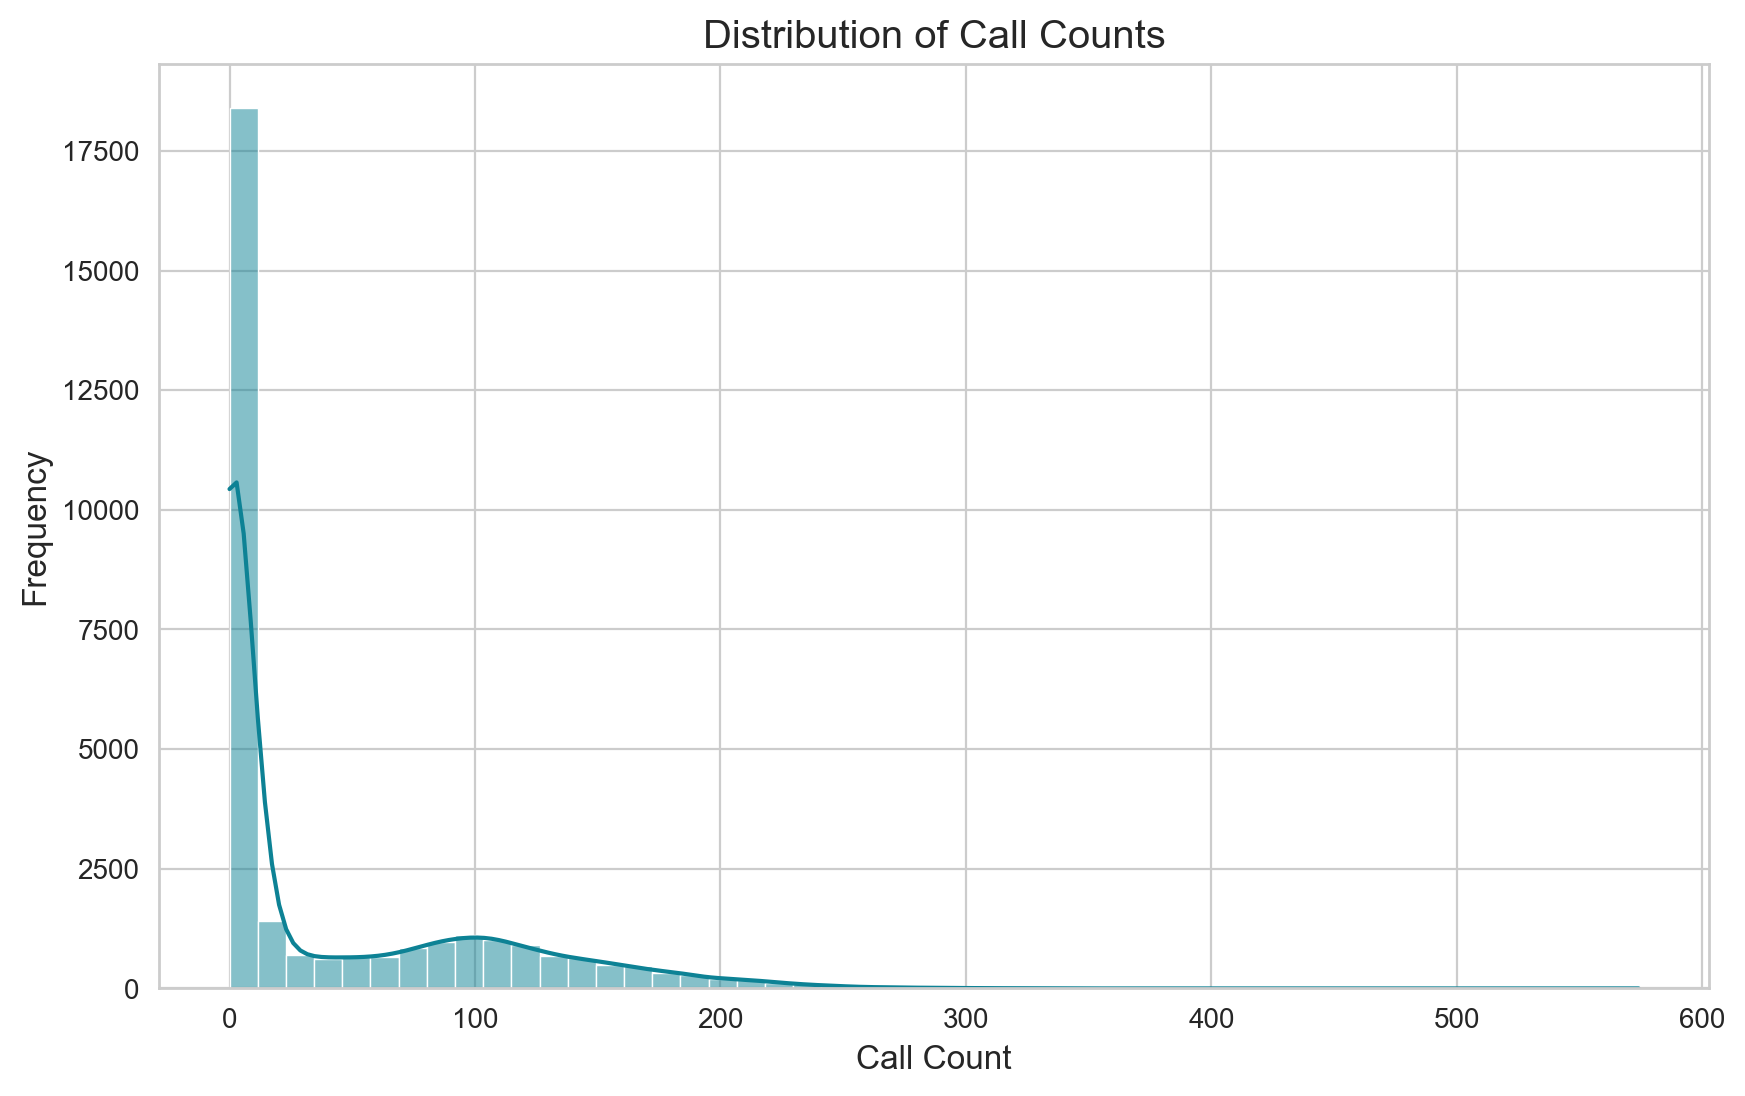

In [7]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot the distribution of the 'count' variable
plt.figure(figsize=(10, 6))
sns.histplot(df1['count'], kde=True, bins=50, color='#0D8295')
plt.title('Distribution of Call Counts')
plt.xlabel('Call Count')
plt.ylabel('Frequency')
plt.show()

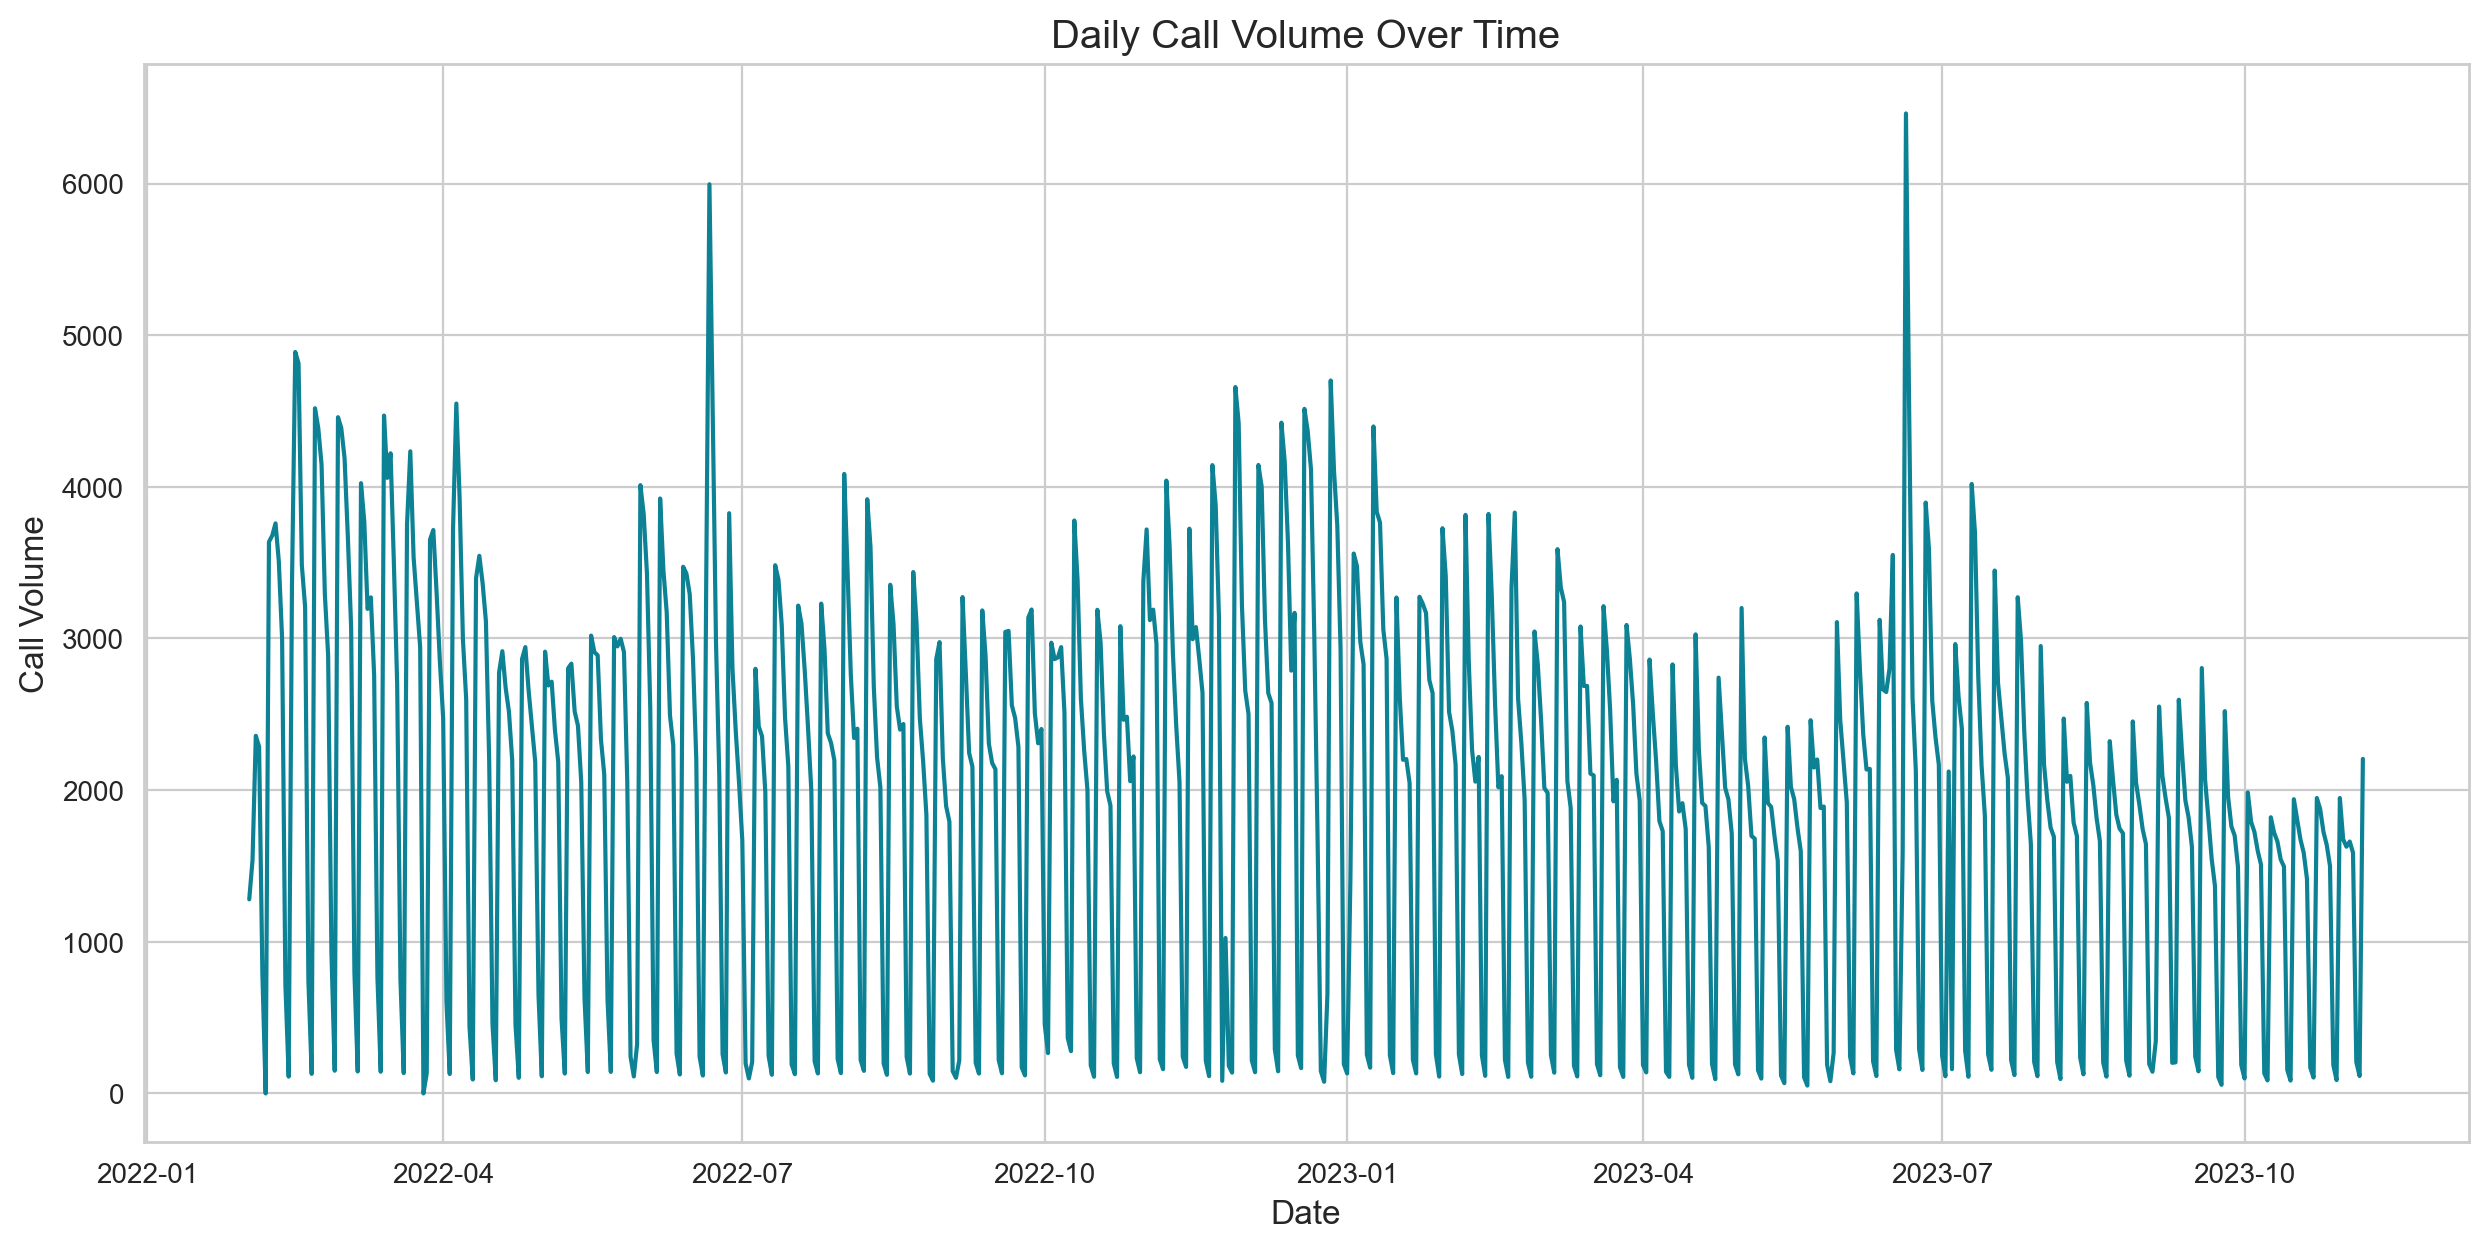

In [8]:
# Resample the data to daily frequency by aggregating counts
daily_data = df1.resample('D', on='date').sum()

# Plot the time series graph of daily call volume
plt.figure(figsize=(15, 7))
sns.lineplot(x=daily_data.index, y='count', data=daily_data, color='#0D8295')
plt.title('Daily Call Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.show()


In [9]:
# Create time-based features for further EDA
df1['hour'] = df1['date'].dt.hour
df1['minute'] = df1['date'].dt.minute
df1['day_of_week'] = df1['date'].dt.dayofweek
df1['day_of_month'] = df1['date'].dt.day
df1['month'] = df1['date'].dt.month
df1['year'] = df1['date'].dt.year
df1['is_weekend'] = df1['day_of_week'].apply(lambda x: 1 if x > 4 else 0)

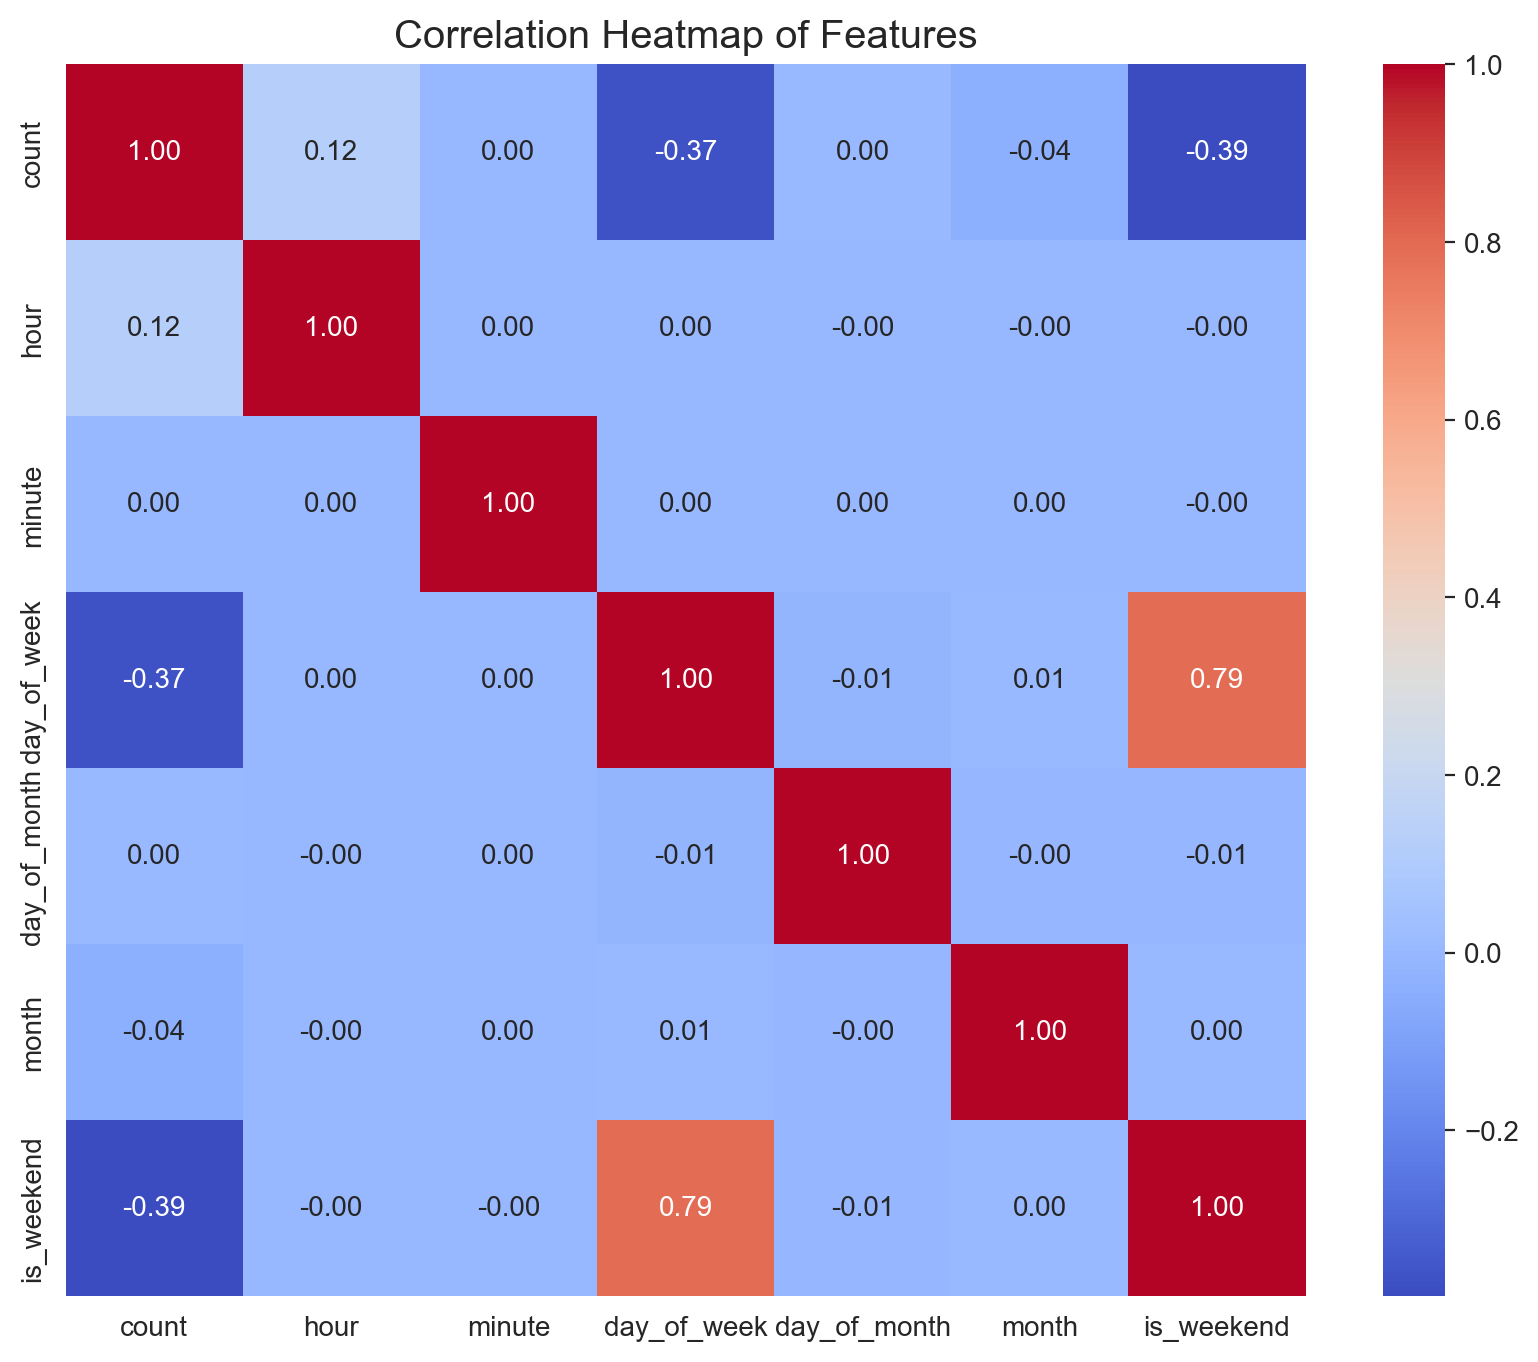

In [10]:
# Calculate correlation matrix for the new features and the count
correlation_matrix = df1[['count', 'hour', 'minute','day_of_week', 'day_of_month', 'month', 'is_weekend']].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Features')
plt.show()


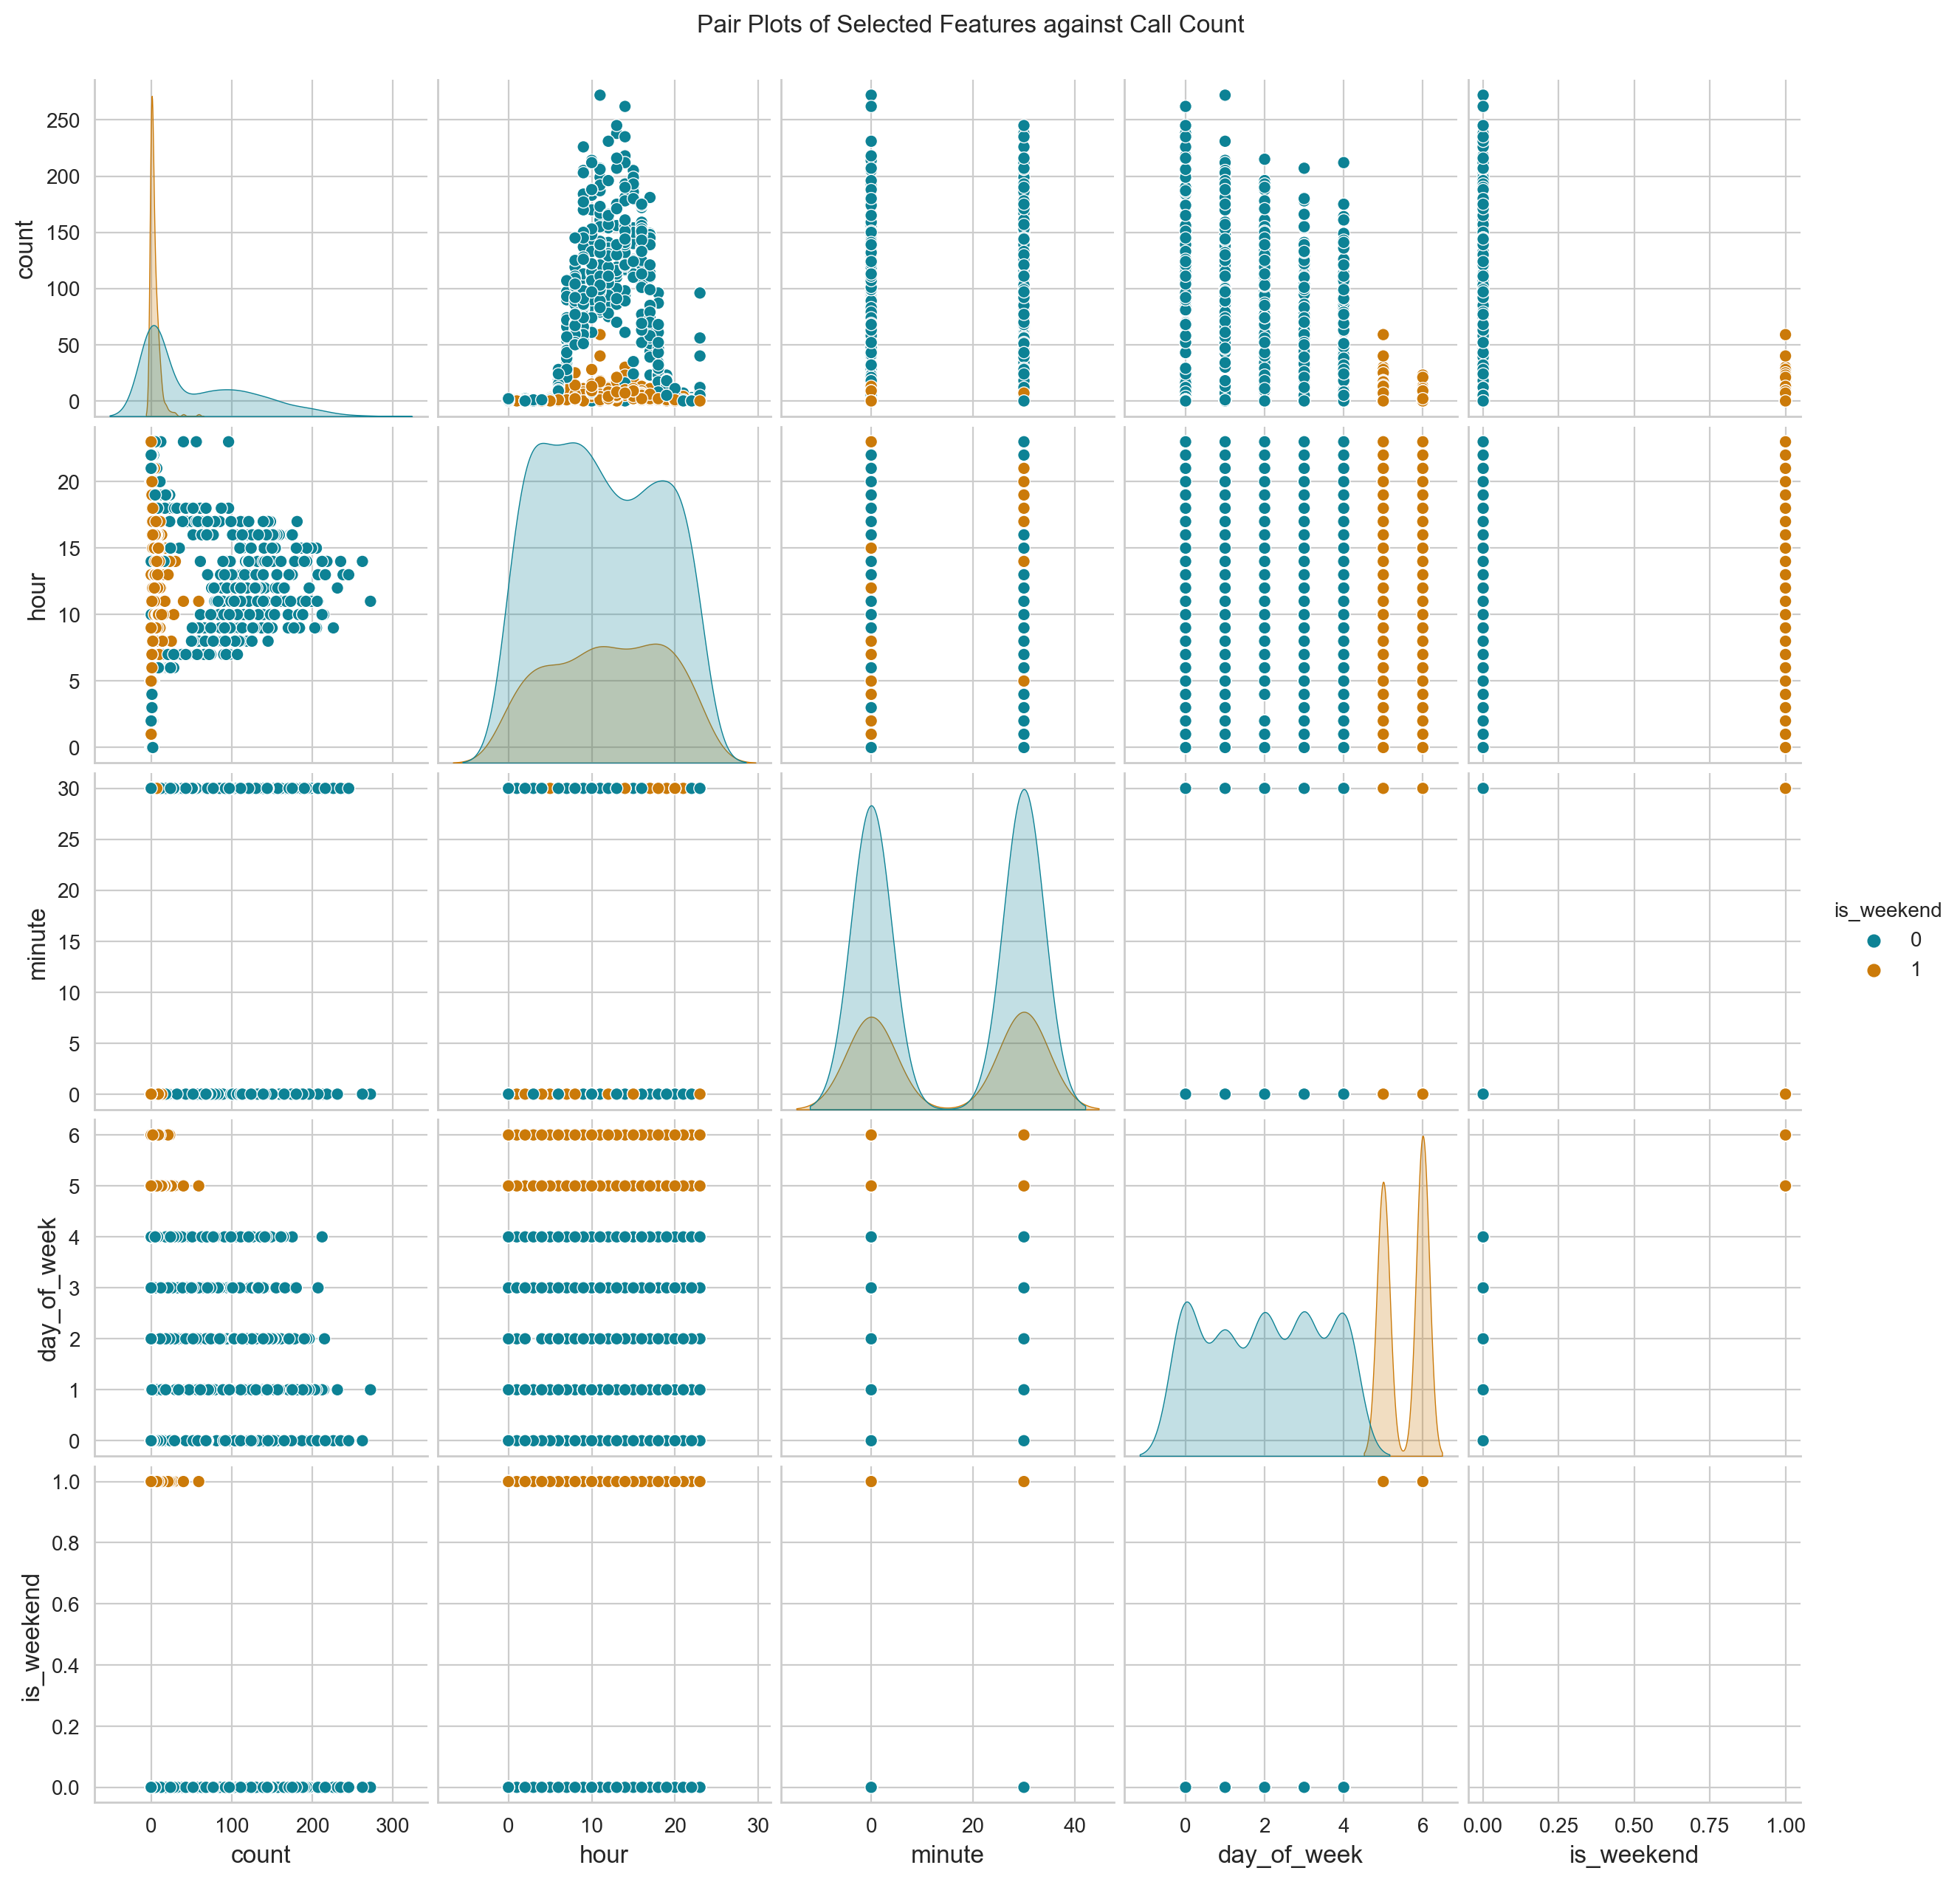

In [11]:
# Select a subset of the data for pair plots to avoid overplotting
subset_data = df1.sample(n=min(1000, len(df1)), random_state=1)

# Create pair plots for selected features against the call count
sns.pairplot(subset_data, vars=['count', 'hour','minute', 'day_of_week', 'is_weekend'], hue='is_weekend', palette=['#0D8295', '#CB7A09'])
plt.suptitle('Pair Plots of Selected Features against Call Count', y=1.02)  # Adjust title position
plt.show()

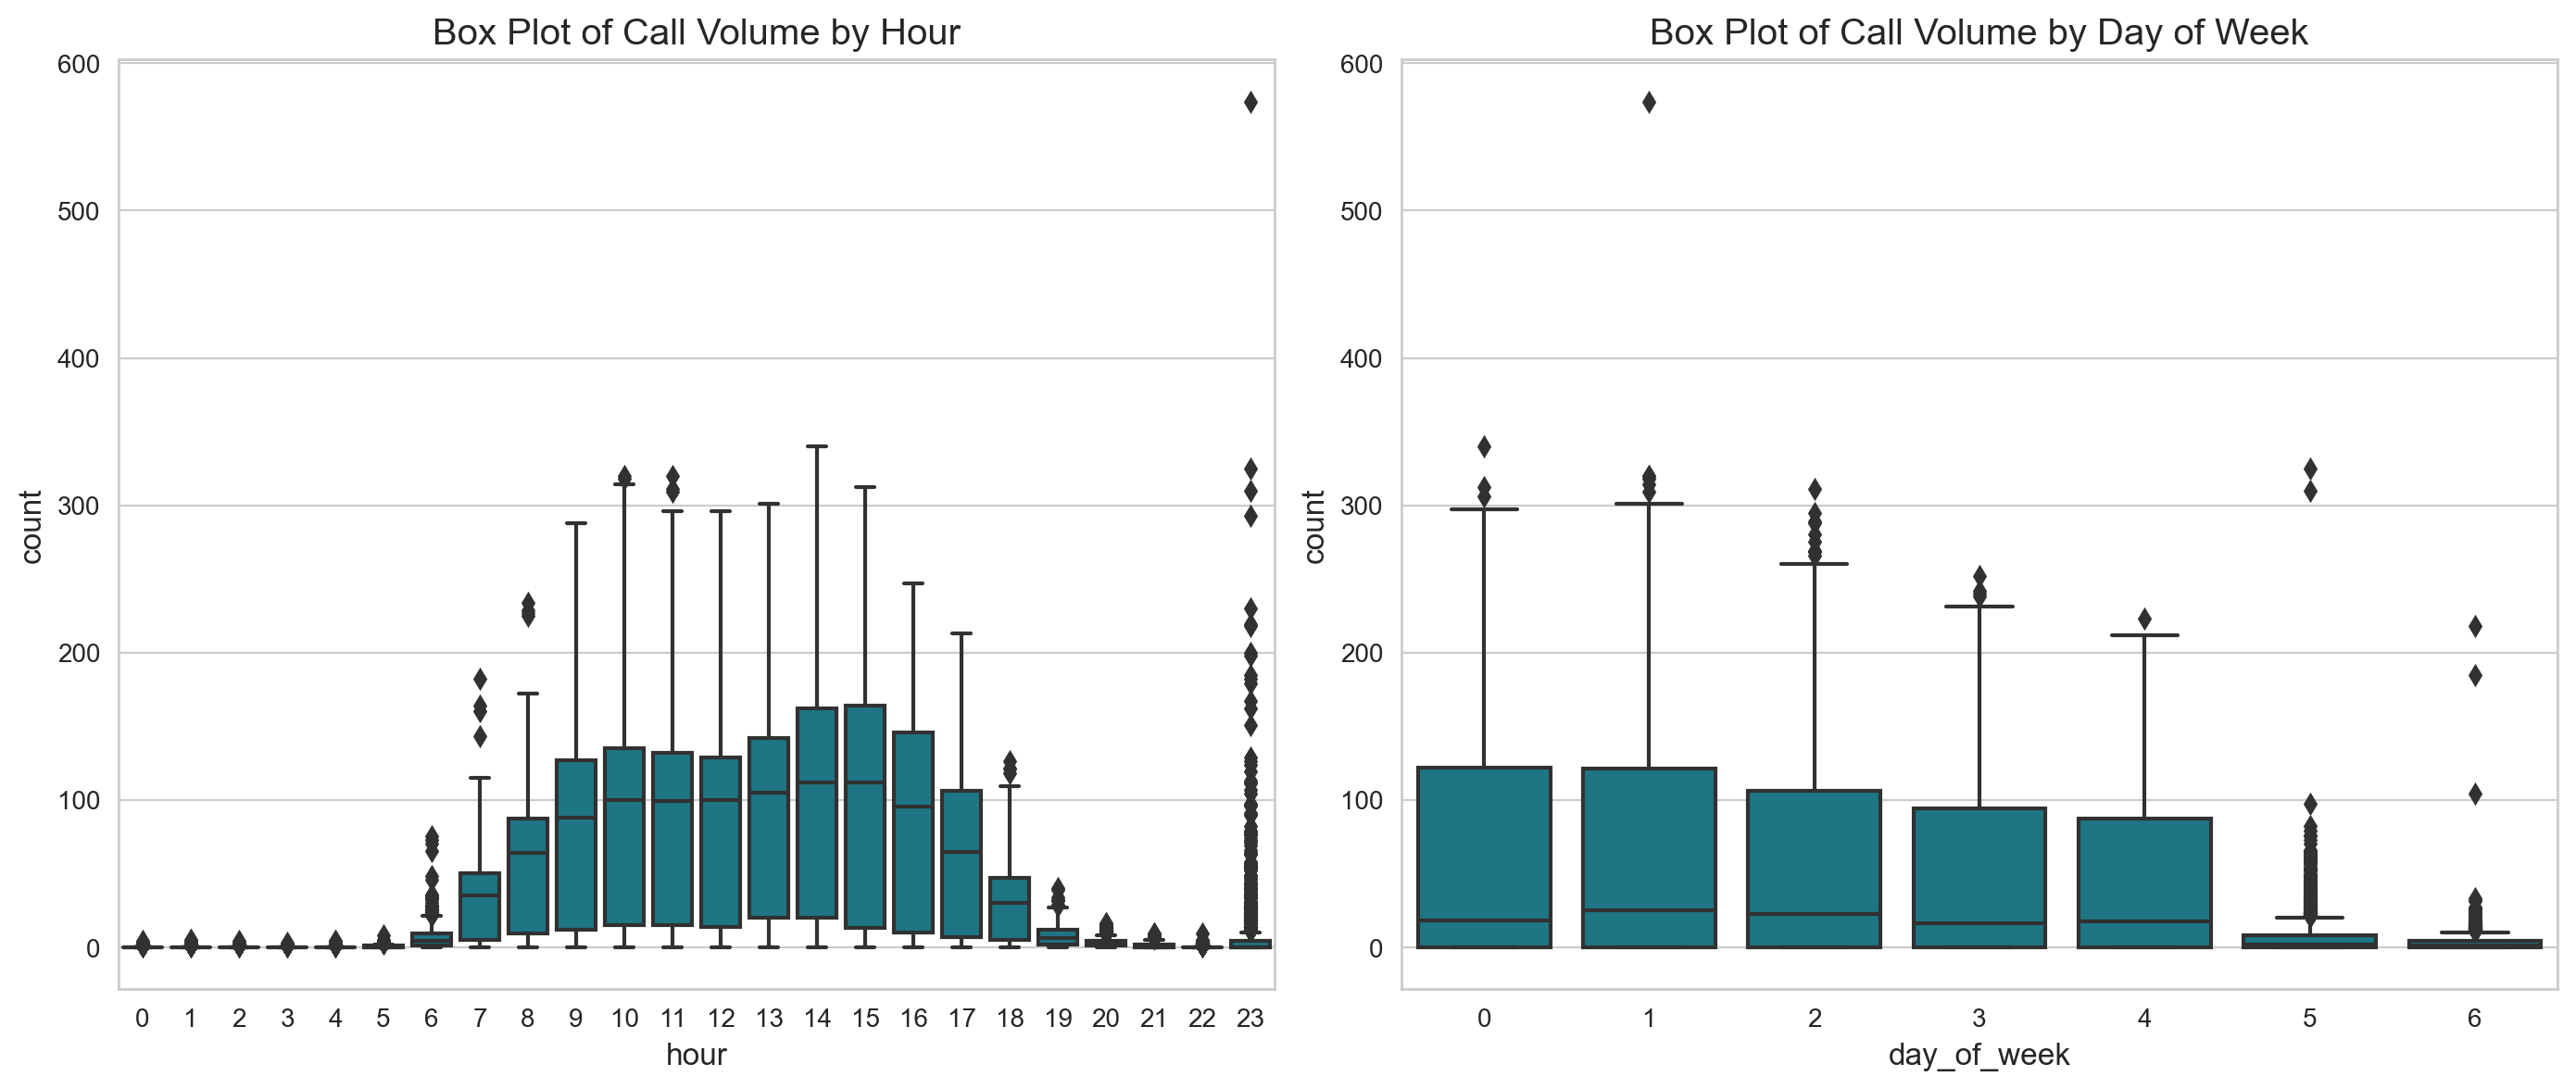

In [12]:
# Create box plots for the 'hour' and 'day_of_week' features against the call count
plt.figure(figsize=(14, 6))

# Box plot for 'hour' feature
plt.subplot(1, 2, 1)
sns.boxplot(x='hour', y='count', data=df1, color='#0D8295')
plt.title('Box Plot of Call Volume by Hour')

# Box plot for 'day_of_week' feature
plt.subplot(1, 2, 2)
sns.boxplot(x='day_of_week', y='count', data=df1, color='#0D8295')
plt.title('Box Plot of Call Volume by Day of Week')

plt.tight_layout()
plt.show()


- The box plot by hour shows variation in median call volume at different times of the day, with some hours having wider interquartile ranges, indicating greater variability in call volume.
- The box plot by day of the week displays the variation in call volumes across different days, with some days showing a higher median call volume and others having a larger spread.

## 3. Data Preparation

- For the third phase of CRISP-DM, we'll be preparing the data for modeling. It's good practice to perform some level of data understanding and preparation manually to ensure the best possible inputs for the model.

### Data cleaning (handling missing values, outliers, etc.)

In [13]:
import numpy as np

# Re-check for missing values in the dataset
missing_values = df1.isnull().sum()

# Re-check for any infinity values in the dataset
inf_values = df1.isin([np.inf, -np.inf]).sum()

print(missing_values)
print('---------------')
print(inf_values)


date            0
count           0
hour            0
minute          0
day_of_week     0
day_of_month    0
month           0
year            0
is_weekend      0
dtype: int64
---------------
date            0
count           0
hour            0
minute          0
day_of_week     0
day_of_month    0
month           0
year            0
is_weekend      0
dtype: int64


##### - There are no missing or value related issues. While there appear to be a couple of outliers, they do occur at the same time of the year over time, so we'll include them in the analysis. 

### Feature engineering and selection.

In [14]:
# Define the number of lags for creating lag features based on the half-hour increments in the data

lags_weeks = [14 * 48, 
              21 * 48, 
              28 * 48, 
              35 * 48, 
              42 * 48, 
              49 * 48, 
              56 * 48, 
              63 * 48, 
              70 * 48]

for lag in lags_weeks:
    df1[f'lag_{int(lag / 48)}d'] = df1['count'].shift(lag).astype('Int64')

# Drop the rows with NaN values created as a result of lagging
data_lagged_clean = df1.dropna().reset_index(drop=True)

# Display the first few rows of the dataframe with new lag features
data_lagged_clean.drop('date', axis=1, inplace=True)


In [15]:
lags_to_int = ['lag_14d', 'lag_21d', 'lag_28d', 'lag_35d', 'lag_42d','lag_49d', 'lag_56d', 'lag_63d', 'lag_70d']
data_lagged_clean[lags_to_int] = data_lagged_clean[lags_to_int].astype('int64')


In [16]:
data_lagged_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27552 entries, 0 to 27551
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   count         27552 non-null  int64
 1   hour          27552 non-null  int64
 2   minute        27552 non-null  int64
 3   day_of_week   27552 non-null  int64
 4   day_of_month  27552 non-null  int64
 5   month         27552 non-null  int64
 6   year          27552 non-null  int64
 7   is_weekend    27552 non-null  int64
 8   lag_14d       27552 non-null  int64
 9   lag_21d       27552 non-null  int64
 10  lag_28d       27552 non-null  int64
 11  lag_35d       27552 non-null  int64
 12  lag_42d       27552 non-null  int64
 13  lag_49d       27552 non-null  int64
 14  lag_56d       27552 non-null  int64
 15  lag_63d       27552 non-null  int64
 16  lag_70d       27552 non-null  int64
dtypes: int64(17)
memory usage: 3.6 MB


### Splitting the dataset into training and testing sets

In [17]:
# Calculate the split index for the last 14 days (14 days * 24 hours * 2 half-hour periods per hour)
split_index_clean = -14 * 24 * 2

# Split the clean data into training and testing sets
train_data_clean = data_lagged_clean[:split_index_clean]
test_data_clean = data_lagged_clean[split_index_clean:]

# Display the shapes of the training and testing sets and the first few rows of the training set
(train_data_clean.shape, test_data_clean.shape,data_lagged_clean.shape)

((26880, 17), (672, 17), (27552, 17))

## 4. Modeling
- Set up the PyCaret environment with the training data and specify the target variable.
- Compare different regression models to identify the best performers for our dataset.
- Use Optuna integration within PyCaret to fine-tune the hyperparameters of the best models.
- Evaluate the tuned models to select the final model for deployment.
---

### Selection of Regression Models for Comparison
- Set up the PyCaret environment with the training data and specify the target variable.
- Compare different regression models to identify the best performers for our dataset.

In [18]:
train_data_clean

,count,hour,minute,day_of_week,day_of_month,month,year,is_weekend,lag_14d,lag_21d,lag_28d,lag_35d,lag_42d,lag_49d,lag_56d,lag_63d,lag_70d
0,1,0,0,1,12,4,2022,0,1,0,0,0,0,0,0,2,0
1,0,0,30,1,12,4,2022,0,0,0,2,0,0,1,0,1,0
2,0,1,0,1,12,4,2022,0,0,1,0,0,0,0,0,0,0
3,0,1,30,1,12,4,2022,0,0,0,1,0,0,0,0,0,0
4,0,2,0,1,12,4,2022,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26875,0,21,30,0,23,10,2023,0,0,0,0,1,0,0,0,0,0
26876,0,22,0,0,23,10,2023,0,0,0,0,0,0,0,0,0,0
26877,0,22,30,0,23,10,2023,0,0,0,0,0,0,0,0,0,0
26878,0,23,0,0,23,10,2023,0,0,0,0,0,0,0,0,0,0


In [19]:
from pycaret.regression import *

total_data = len(train_data_clean)
test_size = 672
train_size_proportion  = (total_data - test_size)/ total_data

# Initialize the setup
exp_reg = setup(data=train_data_clean,
                target='count',
                session_id=123,
                #train_size = train_size_proportion,
                numeric_features=['hour', 'minute', 'day_of_week', 'day_of_month', 'month', 'year', 'is_weekend', 'lag_14d', 'lag_21d', 'lag_28d', 'lag_35d', 'lag_42d', 'lag_49d', 'lag_56d', 'lag_63d', 'lag_70d'],
                fold_strategy='timeseries', # This is important for time series data
                #remove_multicollinearity = True, 
                #multicollinearity_threshold = 0.95,
                fold=5,  # Number of folds for cross-validation
                #data_split_shuffle=False,  # Should be False for time series data
  
               )


,Description,Value
0,Session id,123
1,Target,count
2,Target type,Regression
3,Original data shape,"(26880, 17)"
4,Transformed data shape,"(26880, 17)"
5,Transformed train set shape,"(18816, 17)"
6,Transformed test set shape,"(8064, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


In [20]:
# Compare models to identify top performers
best_model = compare_models(sort='RMSE')  # We sort by RMSE for our initial comparison

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,7.9448,284.7463,16.5886,0.9153,0.5587,0.5798,36.5420
xgboost,Extreme Gradient Boosting,8.1747,295.7713,16.9972,0.9119,0.5548,0.5892,43.7740
et,Extra Trees Regressor,8.0494,304.5958,17.2752,0.9092,0.5504,0.6248,35.9580
rf,Random Forest Regressor,8.4890,351.3287,18.5927,0.8952,0.5608,0.6356,42.7600
gbr,Gradient Boosting Regressor,8.8471,365.3937,19.0002,0.8909,0.6431,0.6230,37.0000
knn,K Neighbors Regressor,9.7785,455.6886,21.2602,0.8638,0.5570,0.6724,45.6860
ridge,Ridge Regression,10.3467,465.2679,21.5144,0.8608,0.8214,0.8699,50.2980
lr,Linear Regression,10.3469,465.2686,21.5145,0.8608,0.8215,0.8700,77.6720
lar,Least Angle Regression,10.3469,465.2686,21.5145,0.8608,0.8215,0.8700,44.7480
br,Bayesian Ridge,10.1857,465.4857,21.5196,0.8607,0.7682,0.8169,37.4220


In [21]:
# Initialize the setup
exp_reg2 = setup(data=train_data_clean,
                target='count',
                session_id=123,
                train_size = train_size_proportion,
                numeric_features=['hour', 'minute', 'day_of_week', 'day_of_month', 'month', 'year', 'is_weekend', 'lag_14d', 'lag_21d', 'lag_28d', 'lag_35d', 'lag_42d', 'lag_49d', 'lag_56d', 'lag_63d', 'lag_70d'],
                fold_strategy='timeseries', # This is important for time series data
                #remove_multicollinearity = True, 
                #multicollinearity_threshold = 0.95,
                fold=5,  # Number of folds for cross-validation
                #data_split_shuffle=False,  # Should be False for time series data
  
               )


,Description,Value
0,Session id,123
1,Target,count
2,Target type,Regression
3,Original data shape,"(26880, 17)"
4,Transformed data shape,"(26880, 17)"
5,Transformed train set shape,"(26208, 17)"
6,Transformed test set shape,"(672, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


In [22]:
# Compare models to identify top performers
best_model2 = compare_models(sort='RMSE')  # We sort by RMSE for our initial comparison


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:24:24
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Bayesian Ridge


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,10.3308,465.0762,21.5414,0.8601,0.8104,0.8598,40.0200
ridge,Ridge Regression,10.3307,465.0762,21.5414,0.8601,0.8103,0.8598,42.8720
lar,Least Angle Regression,10.3308,465.0762,21.5414,0.8601,0.8104,0.8598,42.6400
en,Elastic Net,10.2044,465.4420,21.5501,0.8600,0.7677,0.8181,39.3940
lasso,Lasso Regression,10.1762,465.6529,21.5550,0.8599,0.7566,0.8071,43.8240
omp,Orthogonal Matching Pursuit,12.9810,671.3582,25.9044,0.7980,1.1126,1.1490,52.6900
llar,Lasso Least Angle Regression,47.8592,3323.0458,57.6428,-0.0001,2.5173,7.5750,48.2200


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

### Hyperparameter Tuning
- Use Optuna integration within PyCaret to fine-tune the hyperparameters of the best models.
- Evaluate the tuned models to select the final model for deployment.

In [ ]:
'''
# Create models
huber = create_model('huber')
et = create_model('et')
lightgbm = create_model('lightgbm')

'''

In [ ]:
# List of created models
models = [huber, et, lightgbm]

# Tune models using Optuna
tuned_models = []
for model in models:
    tuned = tune_model(model, optimize='RMSE', n_iter=10)
    tuned_models.append(tuned)

In [ ]:
tuned_models

## 5. Evaluation
- Model performance metrics (RMSE, MAE, R^2, etc.).
- Residual analysis.
- Comparison of model performances.
- Feature importance analysis.
---

In [ ]:
for tuned_model in tuned_models:
    print(f"Evaluating model: {tuned_model}")
    plot_model(tuned_model, plot='residuals')
    plot_model(tuned_model, plot='feature_all')

In [ ]:

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming 'tuned_models' is a list of your tuned models
# And 'test_data_clean' is your separate test dataset with an actual target column named 'count'

# Loop through the list of tuned models
for model in tuned_models:
    # Finalize the model to train on the entire training dataset
    final_model = finalize_model(model)
    
    # Predict on the separate test dataset
    predictions = predict_model(final_model, data=test_data_clean)
    
    # Calculate performance metrics on the test data
    rmse = np.sqrt(mean_squared_error(test_data_clean['count'], predictions['prediction_label']))
    r2 = r2_score(test_data_clean['count'], predictions['prediction_label'])
    mae = mean_absolute_error(test_data_clean['count'], predictions['prediction_label'])
    
    print(f'RMSE on test data: {rmse}')
    print(f'R^2 on test data: {r2}')
    print(f'MAE on test data: {mae}')
    
    # Plot actual vs predicted values for each model
    plt.figure(figsize=(10, 6))
    plt.scatter(test_data_clean['count'], predictions['prediction_label'], alpha=0.5)
    plt.title(f'Actual vs Predicted Values for {model}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.plot([test_data_clean['count'].min(), test_data_clean['count'].max()], 
             [test_data_clean['count'].min(), test_data_clean['count'].max()], 'k--', lw=4)
    plt.show()
    
    # Additional plots or metrics can be added here as necessary


##### Based on the evaluation of the models, we'll put both into production for comparison in real-world testing. 

## 6. Deployment
- Final model selection.
- Saving the model for future use.
- Recommendations and strategies for deployment.
---

In [ ]:
data_lagged_clean

In [ ]:


total_data = len(data_lagged_clean)
test_size = 672
train_size_proportion  = (total_data - test_size)/ total_data

# Initialize the setup
final_reg = setup(data=data_lagged_clean,
                target='count',
                session_id=123,
                train_size = train_size_proportion,
                numeric_features=['hour', 'day_of_week', 'day_of_month', 'month', 'year', 'is_weekend', 'lag_14d', 'lag_21d', 'lag_28d', 'lag_35d', 'lag_42d', 'lag_49d', 'lag_56d', 'lag_63d', 'lag_70d'],
                fold_strategy='timeseries', # This is important for time series data
                remove_multicollinearity = True, 
                multicollinearity_threshold = 0.95,
                fold=5,  # Number of folds for cross-validation
                data_split_shuffle=False,  # Should be False for time series data
  
               )

In [ ]:
''' Extra Trees Regressor'''

et_params = {'bootstrap':True, 
             'criterion' :'absolute_error', 
             'max_depth' : 7,
             'max_features' : 0.6537106665170453,
             'min_impurity_decrease' : 6.57655501374889e-07,
             'min_samples_leaf': 2, 
             'n_estimators': 276, 
             'n_jobs': -1,
             'random_state': 123}

huber_params = {'alpha': 0.7760031625333533, 
                'epsilon': 1.9245155222775643}

In [ ]:
et_model = create_model('et',**et_params)

In [ ]:
tuned_et = finalize_model(et_model)

## Final Report
- Summary of findings.
- Visualizations styled using 'The Economist' style guide.
- Conclusions and actionable insights.
- Next steps and recommendations for business.
---